In [17]:
a= "December special project"
b= "Satellite Image Processing"
c= "Prateek Dutta & Abhiroop Sarkar"
print("Introducing",a,"on",b,"created by",c)

Introducing December special project on Satellite Image Processing created by Prateek Dutta & Abhiroop Sarkar


In [18]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
/gdrive


In [19]:
ls

MyDrive/  Shareddrives/


In [20]:
cd/gdrive/MyDrive/Elephant classification/

/gdrive/.shortcut-targets-by-id/1LS3pI66z9D2CAKYOrXwmowk2p9AKTvMX/Elephant classification


In [21]:
ls

dataset/


In [22]:
cd/gdrive/MyDrive/Elephant classification/dataset/

/gdrive/.shortcut-targets-by-id/1LS3pI66z9D2CAKYOrXwmowk2p9AKTvMX/Elephant classification/dataset


In [23]:
ls

test/  train/


In [24]:
cd/gdrive/MyDrive/Elephant classification/dataset/test/

/gdrive/.shortcut-targets-by-id/1LS3pI66z9D2CAKYOrXwmowk2p9AKTvMX/Elephant classification/dataset/test


In [25]:
ls

African/  Asian/  sequential-satellite_img.h5


In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [27]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [28]:
#from google.colab import drive
#drive.mount('/content/drive')

In [29]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=30
CHANNELS=3

In [30]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Elephant classification/dataset/test/",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 188 files belonging to 2 classes.


In [31]:
class_names = dataset.class_names
class_names

['African', 'Asian']

In [32]:
len(dataset)

4

In [33]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[ 20.62687    52.819717   30.670517 ]
  [ 15.018921   37.725952   21.536499 ]
  [ 40.8777     60.829384   50.386024 ]
  ...
  [  8.884254    8.884254    8.884254 ]
  [  4.5039062   4.5039062   4.5039062]
  [ 10.458305   10.458305   10.458305 ]]

 [[  3.3777924  33.04576    16.475365 ]
  [ 30.929817   63.08071    42.033585 ]
  [ 25.200203   58.527214   37.39203  ]
  ...
  [  9.401924    9.401924    9.401924 ]
  [  2.4472656   2.4472656   2.4472656]
  [ 11.609375   11.609375   11.609375 ]]

 [[ 12.285011   43.630806   26.48967  ]
  [ 40.77024    75.77024    53.77024  ]
  [ 12.7445755  50.097054   29.123192 ]
  ...
  [  7.127411    7.127411    7.127411 ]
  [  2.7152634   2.7152634   2.7152634]
  [  9.546364    9.546364    9.546364 ]]

 ...

 [[193.95142   178.39673   156.22876  ]
  [196.38434   175.88824   156.72028  ]
  [172.83716   150.22388   136.22388  ]
  ...
  [ 56.71605   110.16392    61.730927 ]
  [ 74.818054  127.77118    72.31917  ]
  [ 92.80149   

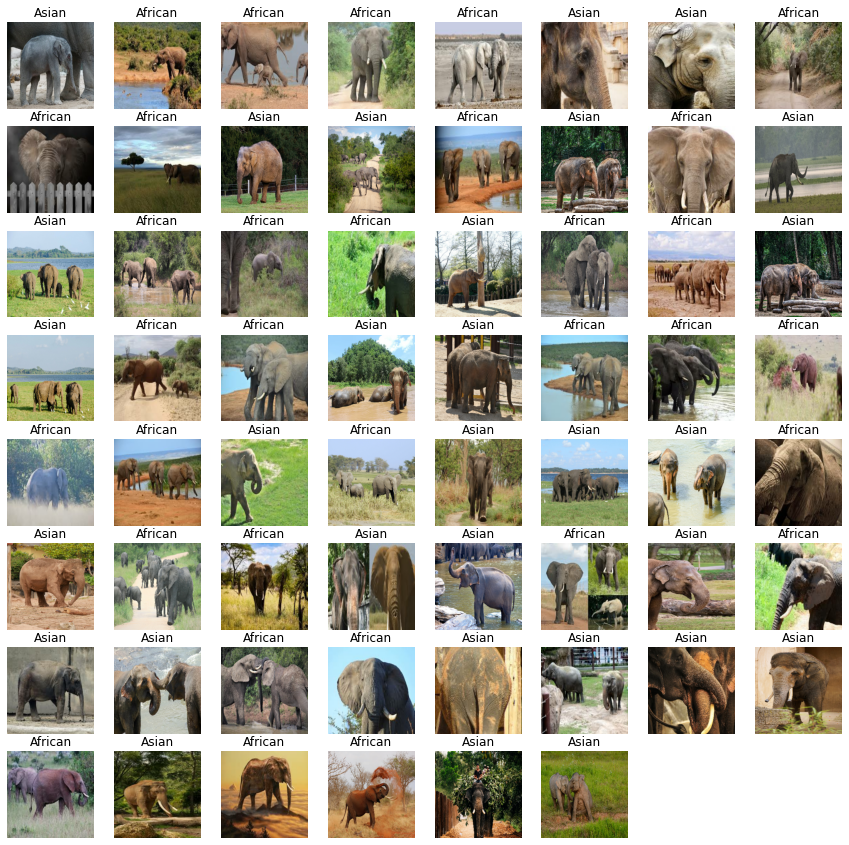

In [34]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [35]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [36]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [37]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [38]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
3/3 [==============================] - 16s 3s/step - loss: 1.9567 - accuracy: 0.3571
Epoch 2/30
3/3 [==============================] - 12s 3s/step - loss: 1.3597 - accuracy: 0.6032
Epoch 3/30
3/3 [==============================] - 12s 3s/step - loss: 1.1689 - accuracy: 0.6032
Epoch 4/30
3/3 [==============================] - 12s 3s/step - loss: 0.7300 - accuracy: 0.4603
Epoch 5/30
3/3 [==============================] - 12s 6s/step - loss: 0.7393 - accuracy: 0.6032
Epoch 6/30
3/3 [==============================] - 12s 3s/step - loss: 0.8011 - accuracy: 0.6032
Epoch 7/30
3/3 [==============================] - 12s 6s/step - loss: 0.8750 - accuracy: 0.6032
Epoch 8/30
3/3 [==============================] - 12s 6s/step - loss: 0.7691 - accuracy: 0.6032
Epoch 9/30
3/3 [==============================] - 12s 3s/step - loss: 0.7119 - accuracy: 0.6032
Epoch 10/30
3/3 [==============================] - 12s 6s/step - loss: 0.6802 - accuracy: 0.6032
Epoch 11/30
3/3 [======================

In [43]:
model.evaluate(test_ds)

1/1 [==============================] - 4s 4s/step - loss: 0.4988 - accuracy: 0.7581


[0.49883636832237244, 0.7580645084381104]

In [44]:
acc = history.history['accuracy']
loss = history.history['loss']

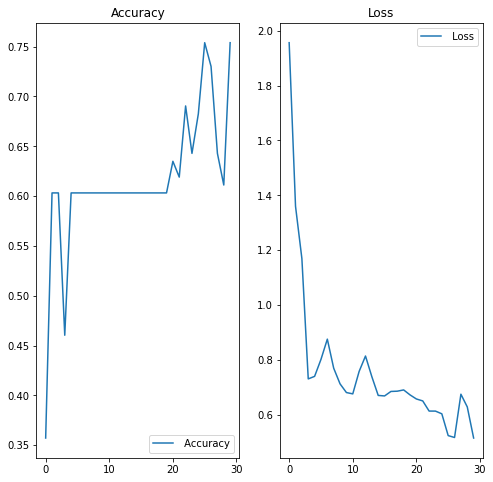

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

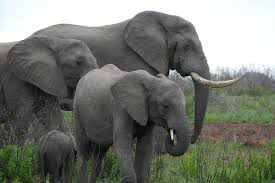

In [46]:
image_path = "/gdrive/MyDrive/Elephant classification/dataset/test/African/af_te19.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [47]:
pred = model.predict(scaled_img)

In [48]:
output = class_names[np.argmax(pred)]

In [49]:
output

'African'

In [50]:
model.save("sequential-satellite_img.h5")